In [1]:
using HDF5
using LaTeXStrings
using PyPlot
using DelimitedFiles

In [2]:
# the function lists all h5 files in a directory
function list_h5_files(foldername::String; prefix::String="data_")
    path     = abspath(foldername)
    allfiles = readdir(path)

    Ns = length(prefix)

    its_names = Tuple[]
    # append only the files whose names start with the given prefix
    for file in allfiles
        try
            if (file[1:Ns] == prefix && file[end-2:end] == ".h5")
                # extract iteration
                it_str = file[Ns+1:end-3]
                fullname = joinpath(path, file)
                # add to list of tuples with iteration and name
                push!(its_names, (parse(Int64, it_str), fullname))
            end
        catch ex
            if isa(ex, BoundsError)
                # probably triggered by string comparison; do nothing
            else
                throw(ex)
            end
        end
    end

    # sort according to iteration
    sort!(its_names)
    # and extract the list of filenames and iterations
    filenames = [name for (it, name) in its_names]
    its       = [it for (it, name) in its_names]

    (its, filenames)
end

list_h5_files (generic function with 1 method)

In [3]:
# give the directory where the data from all the runs are saved
your_dir = "/home/thanasis/repos/model_CCE_CCM_public/examples/run_ccm/SYMH_B1_WH_B2_smooth_t20"

"/home/thanasis/repos/model_CCE_CCM_public/examples/run_ccm/SYMH_B1_WH_B2_smooth_t20"

In [4]:
# SH model
data_dir_SH = your_dir

#N=3 the times we doubled from Nx=17 to get this resolution
Nx = 33#17
Nz = 32#16 #coarse
# the overal course graining
n = 0

# load the ρ grid
ρc = h5read(data_dir_SH * "/data_$((Nx-1)*2^n + 1)_$((Nz)*2^n)/ρ.h5","ρ")
dρc = ρc[2] - ρc[1]
ρm = h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+1) + 1)_$((Nz)*2^(n+1))/ρ.h5","ρ")
ρf = h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+2) + 1)_$((Nz)*2^(n+2))/ρ.h5","ρ")
# load the x grid
xc = h5read(data_dir_SH * "/data_$((Nx-1)*2^n + 1)_$((Nz)*2^n)/X.h5","X")
dxc = xc[2] - xc[1]
xm = h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+1) + 1)_$((Nz)*2^(n+1))/X.h5","X")
xf = h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+2) + 1)_$((Nz)*2^(n+2))/X.h5","X")
# load the z grid
zc = h5read(data_dir_SH*"/data_$((Nx-1)*2^n + 1)_$((Nz)*2^n)/z.h5","z")
zρc = zc[2] - zc[1]
zm = h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+1) + 1)_$((Nz)*2^(n+1))/z.h5","z")
zf = h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+2) + 1)_$((Nz)*2^(n+2))/z.h5","z")

# list all available iterations (and corresponding files)
(its_c, all_filenames_c) = list_h5_files(data_dir_SH*"/data_$((Nx-1)*2^n + 1)_$((Nz)*2^n)", prefix="data_")
(its_m, all_filenames_m) = list_h5_files(data_dir_SH*"/data_$((Nx-1)*2^(n+1) + 1)_$((Nz)*2^(n+1))", prefix="data_")
(its_f, all_filenames_f) = list_h5_files(data_dir_SH*"/data_$((Nx-1)*2^(n+2) + 1)_$((Nz)*2^(n+2))", prefix="data_")

# lists used in checking if the projection on the coarse grid is done correctly
#ρm_c = zeros(length(ρc));
@assert ρc ≈ ρm[1:2:end]
@assert ρc ≈ ρf[1:4:end]


In [5]:
#choose the commmon timestep to do the comparison.
#remember that its_c =its_m[1:2:end] = its_c[1:4:end]
#it_c is the timestep of the coarse resolution    
i = 250
#saved only on common timesteps
it_c = its_c[i]#[1+i] # when saved on al timesteps
it_m = its_m[i]#[1+2*i]
it_f = its_f[i]#[1+2*2*i]
it_str_c  = lpad(it_c, 4, "0")
it_str_m  = lpad(it_m, 4, "0")
it_str_f  = lpad(it_f, 4, "0")

ϕ1c  =  h5read(data_dir_SH*"/data_$((Nx-1)*2^n + 1)_$((Nz)*2^n)/data_$(it_str_c).h5","ϕ1")
ψv1c =  h5read(data_dir_SH*"/data_$((Nx-1)*2^n + 1)_$((Nz)*2^n)/data_$(it_str_c).h5","ψv1")
ψ1c  =  h5read(data_dir_SH*"/data_$((Nx-1)*2^n + 1)_$((Nz)*2^n)/data_$(it_str_c).h5","ψ1")
ϕ2c  =  h5read(data_dir_SH*"/data_$((Nx-1)*2^n + 1)_$((Nz)*2^n)/data_$(it_str_c).h5","ϕ2")
ψv2c =  h5read(data_dir_SH*"/data_$((Nx-1)*2^n + 1)_$((Nz)*2^n)/data_$(it_str_c).h5","ψv2")
ψ2c  =  h5read(data_dir_SH*"/data_$((Nx-1)*2^n + 1)_$((Nz)*2^n)/data_$(it_str_c).h5","ψ2")
tc   =  h5readattr(data_dir_SH*"/data_$((Nx-1)*2^n + 1)_$((Nz)*2^n)/data_$(it_str_c).h5", "/")["time"]

ϕ1m   =  h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+1) + 1)_$((Nz)*2^(n+1))/data_$(it_str_m).h5","ϕ1")
ψv1m  =  h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+1) + 1)_$((Nz)*2^(n+1))/data_$(it_str_m).h5","ψv1")
ψ1m   =  h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+1) + 1)_$((Nz)*2^(n+1))/data_$(it_str_m).h5","ψ1")
ϕ2m   =  h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+1) + 1)_$((Nz)*2^(n+1))/data_$(it_str_m).h5","ϕ2")
ψv2m  =  h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+1) + 1)_$((Nz)*2^(n+1))/data_$(it_str_m).h5","ψv2")
ψ2m   =  h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+1) + 1)_$((Nz)*2^(n+1))/data_$(it_str_m).h5","ψ2")
tm    =  h5readattr(data_dir_SH*"/data_$((Nx-1)*2^(n+1) + 1)_$((Nz)*2^(n+1))/data_$(it_str_m).h5", "/")["time"] 

ϕ1f   =  h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+2) + 1)_$((Nz)*2^(n+2))/data_$(it_str_f).h5","ϕ1")
ψv1f  =  h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+2) + 1)_$((Nz)*2^(n+2))/data_$(it_str_f).h5","ψv1")
ψ1f   =  h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+2) + 1)_$((Nz)*2^(n+2))/data_$(it_str_f).h5","ψ1")
ϕ2f   =  h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+2) + 1)_$((Nz)*2^(n+2))/data_$(it_str_f).h5","ϕ2")
ψv2f  =  h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+2) + 1)_$((Nz)*2^(n+2))/data_$(it_str_f).h5","ψv2")
ψ2f   =  h5read(data_dir_SH*"/data_$((Nx-1)*2^(n+2) + 1)_$((Nz)*2^(n+2))/data_$(it_str_f).h5","ψ2")
tf    =  h5readattr(data_dir_SH*"/data_$((Nx-1)*2^(n+2) + 1)_$((Nz)*2^(n+2))/data_$(it_str_f).h5", "/")["time"]

# make sure we're comparing the same timestep
@assert tc ≈ tm
@assert tc ≈ tf
println(tc)

15.5625


15.5625
1.1780972450961724
1.1780972450961724
1.1780972450961724


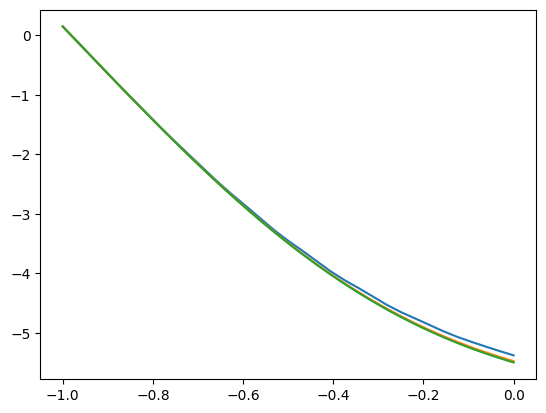

In [6]:
# ϕ1

zic = 7
plot(ρc, ϕ1c[:,zic])
plot(ρm, ϕ1m[:,2*zic-1])
plot(ρf, ϕ1f[:,4*zic-3])
println(tc)
println(zc[zic])
println(zm[2*zic-1])
println(zf[4*zic-3])

15.5625
-0.71875
-0.71875
-0.71875


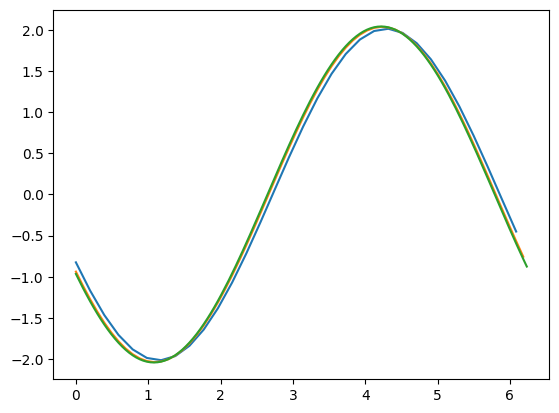

In [7]:
ρic = 10
plot(zc, ϕ1c[ρic,:])
plot(zm, ϕ1m[2*ρic-1,:])
plot(zf, ϕ1f[4*ρic-3,:])
println(tc)
println(ρc[ρic])
println(ρm[2*ρic-1])
println(ρf[4*ρic-3])

15.5625

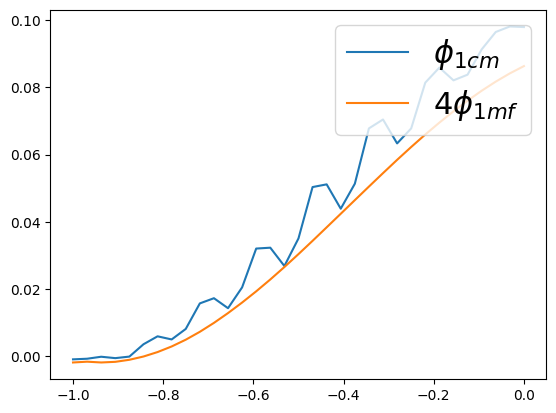

In [8]:
ϕ1cm = ϕ1c - ϕ1m[1:2:end,1:2:end]
ϕ1mf = ϕ1m[1:2:end,1:2:end] - ϕ1f[1:4:end,1:4:end]

plot(ρc, ϕ1cm[:,zic], label =L"\phi_{1cm}")
plot(ρc, 4*ϕ1mf[:,zic], label =L"4\phi_{1mf}")
legend(fontsize="22", loc=1)
print(tc)

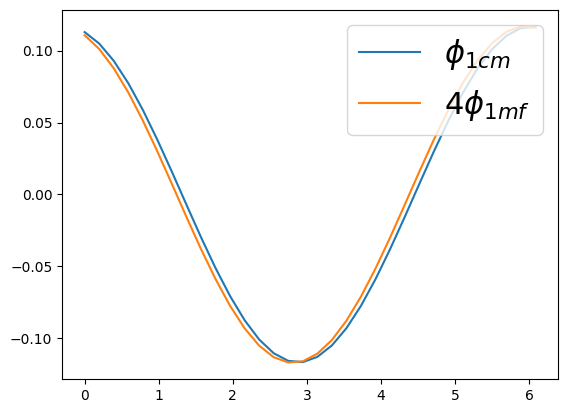

PyObject <matplotlib.legend.Legend object at 0x7f0362861710>

In [9]:
plot(zc, ϕ1cm[ρic,:], label =L"\phi_{1cm}")
plot(zc, 4*ϕ1mf[ρic,:], label =L"4\phi_{1mf}")
legend(fontsize="22", loc=1)

0.0
0.0
0.0


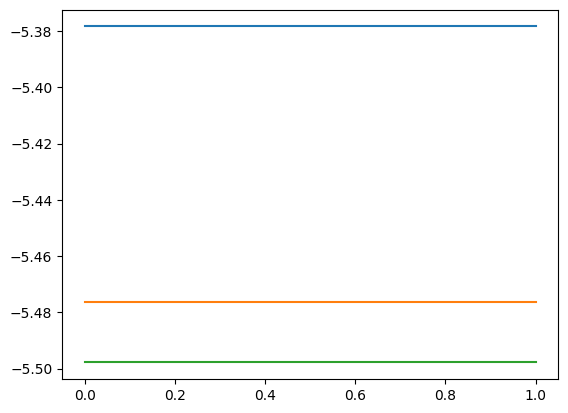

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f03627ea7b8>

In [10]:
#ϕ2
println(maximum(ϕ1c[end,:].-ϕ2c[1,:]))
println(maximum(ϕ1m[end,:].-ϕ2m[1,:]))
println(maximum(ϕ1f[end,:].-ϕ2f[1,:]))
plot(xc, ϕ2c[:,zic])
plot(xm, ϕ2m[:,2*zic-1])
plot(xf, ϕ2f[:,4*zic-3])

15.5625
0.28125
0.28125
0.28125


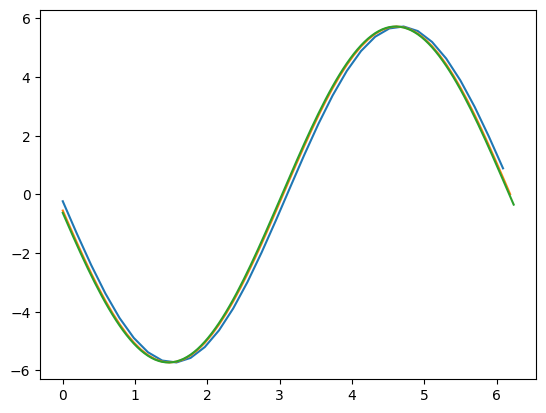

In [11]:
xic = 10
plot(zc, ϕ2c[xic,:])
plot(zm, ϕ2m[2*xic-1,:])
plot(zf, ϕ2f[4*xic-3,:])
println(tc)
println(xc[xic])
println(xm[2*xic-1])
println(xf[4*xic-3])

15.5625

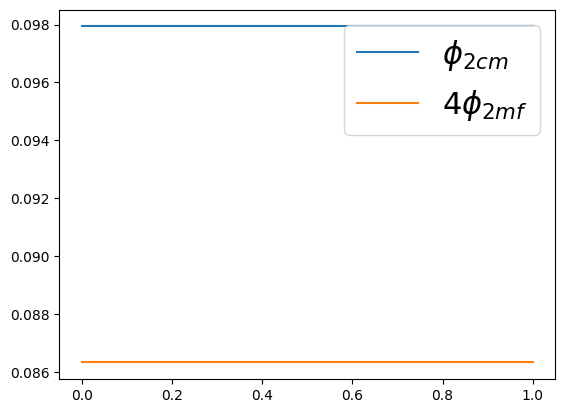

In [12]:
ϕ2cm = ϕ2c - ϕ2m[1:2:end,1:2:end]
ϕ2mf = ϕ2m[1:2:end,1:2:end] - ϕ2f[1:4:end,1:4:end]

plot(xc, ϕ2cm[:,zic], label =L"\phi_{2cm}")
plot(xc, 4*ϕ2mf[:,zic], label =L"4\phi_{2mf}")
legend(fontsize="22", loc=1)
print(tc)

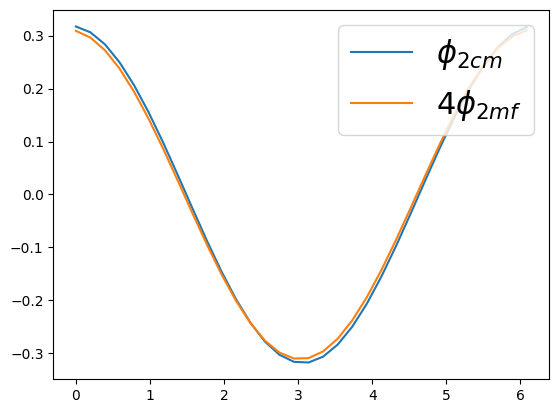

PyObject <matplotlib.legend.Legend object at 0x7f03626f9978>

In [13]:
plot(zc, ϕ2cm[xic,:], label =L"\phi_{2cm}")
plot(zc, 4*ϕ2mf[xic,:], label =L"4\phi_{2mf}")
legend(fontsize="22", loc=1)

15.5625

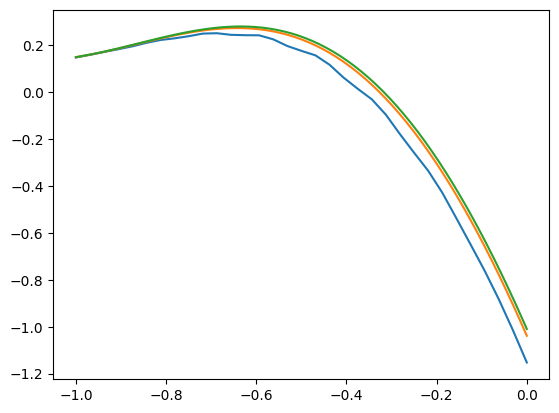

In [14]:
#ψv1
plot(ρc, ψv1c[:,zic])
plot(ρm, ψv1m[:,2*zic-1])
plot(ρf, ψv1f[:,4*zic-3])
print(tc)

15.5625
-0.71875


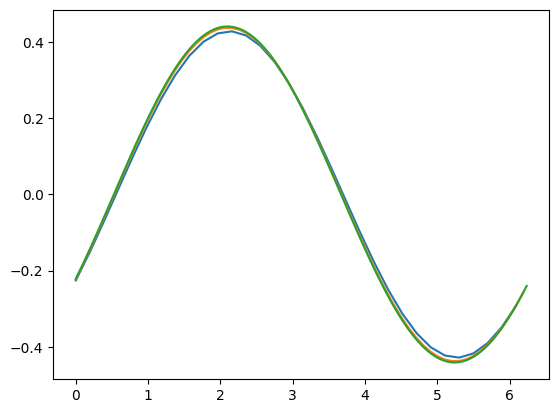

In [15]:
ρic = 10
plot(zc, ψv1c[ρic,:])
plot(zm, ψv1m[2*ρic-1,:])
plot(zf, ψv1f[4*ρic-3,:])
println(tc)
println(ρc[ρic])

15.5625

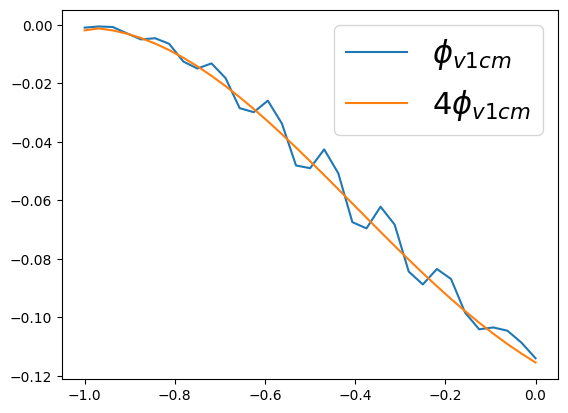

In [16]:
ψv1cm = ψv1c - ψv1m[1:2:end,1:2:end]
ψv1mf = ψv1m[1:2:end,1:2:end] - ψv1f[1:4:end,1:4:end]

plot(ρc, ψv1cm[:,zic], label =L"\phi_{v1cm}")
plot(ρc, 4*ψv1mf[:,zic], label =L"4\phi_{v1cm}")
legend(fontsize="22", loc=1)
print(tc)

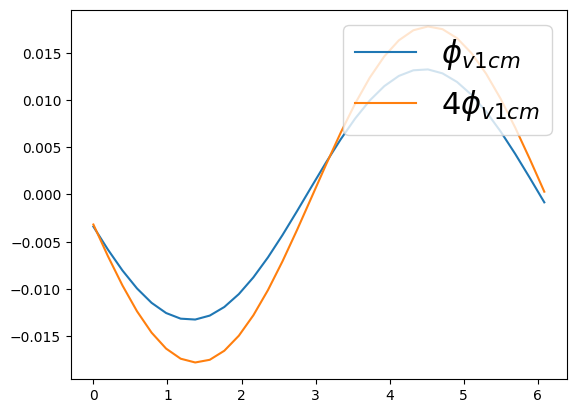

PyObject <matplotlib.legend.Legend object at 0x7f036267f438>

In [17]:
plot(zc, ψv1cm[ρic,:], label =L"\phi_{v1cm}")
plot(zc, 4*ψv1mf[ρic,:], label =L"4\phi_{v1cm}")
legend(fontsize="22", loc=1)


0.0
0.0
0.0
15.5625

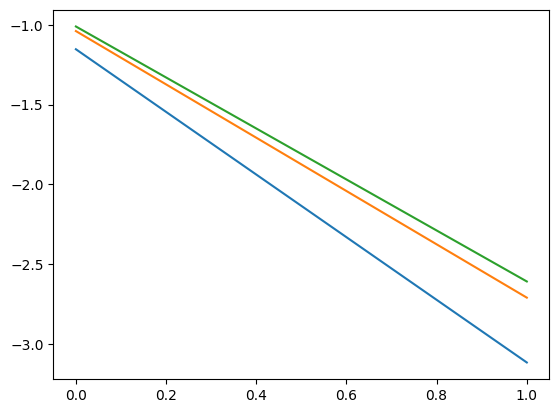

In [18]:
#ψv2
println(maximum(ψv1c[end,:].-ψv2c[1,:]))
println(maximum(ψv1m[end,:].-ψv2m[1,:]))
println(maximum(ψv1f[end,:].-ψv2f[1,:]))
plot(xc, ψv2c[:,zic])
plot(xm, ψv2m[:,2*zic-1])
plot(xf, ψv2f[:,4*zic-3])
print(tc)

15.5625

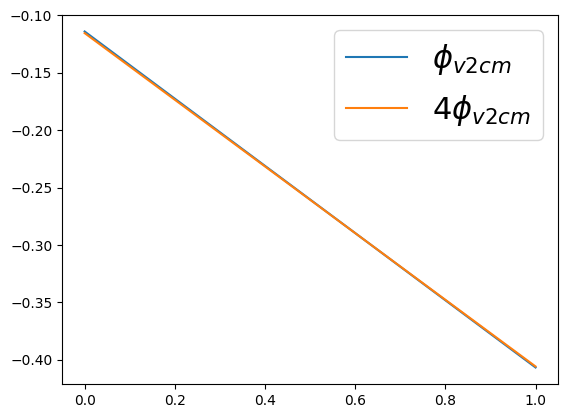

In [19]:
ψv2cm = ψv2c - ψv2m[1:2:end,1:2:end]
ψv2mf = ψv2m[1:2:end,1:2:end] - ψv2f[1:4:end,1:4:end]

plot(xc, ψv2cm[:,zic], label =L"\phi_{v2cm}")
plot(xc, 4*ψv2mf[:,zic], label =L"4\phi_{v2cm}")
legend(fontsize="22", loc=1)

print(tc)

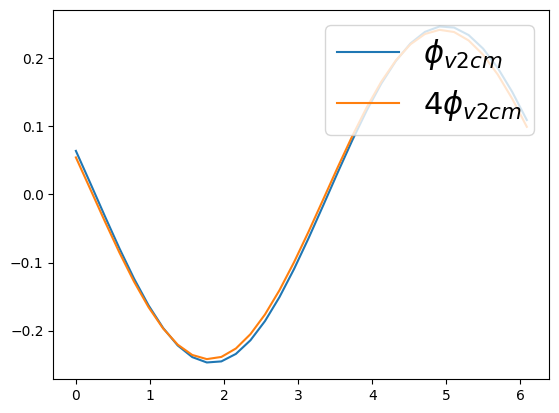

PyObject <matplotlib.legend.Legend object at 0x7f03629febe0>

In [20]:
plot(zc, ψv2cm[xic,:], label =L"\phi_{v2cm}")
plot(zc, 4*ψv2mf[xic,:], label =L"4\phi_{v2cm}")
legend(fontsize="22", loc=1)

15.5625

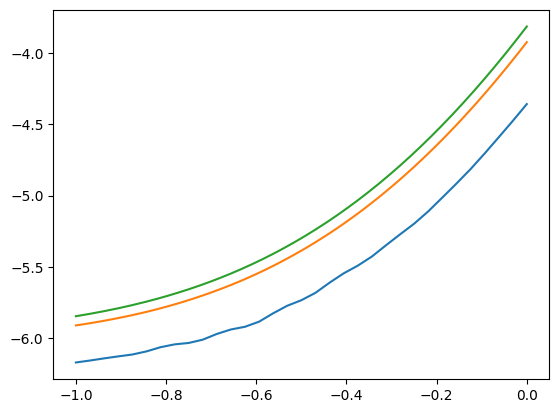

In [21]:
#ψ1
zic = 5*2
plot(ρc, ψ1c[:,zic])
plot(ρm, ψ1m[:,2*zic-1])
plot(ρf, ψ1f[:,4*zic-3])
print(tc)

15.5625

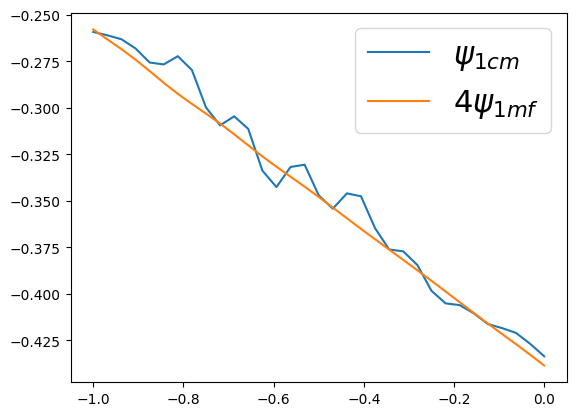

In [22]:
ψ1cm = ψ1c - ψ1m[1:2:end,1:2:end]
ψ1mf = ψ1m[1:2:end,1:2:end] - ψ1f[1:4:end,1:4:end]

plot(ρc, ψ1cm[:,zic], label =L"\psi_{1cm}")
plot(ρc, 4*ψ1mf[:,zic], label =L"4\psi_{1mf}")
legend(fontsize="22", loc=1)
print(tc)

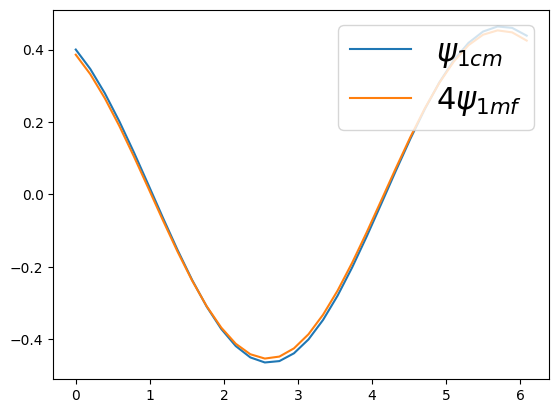

PyObject <matplotlib.legend.Legend object at 0x7f036241f4e0>

In [23]:
plot(zc, ψ1cm[ρic,:], label =L"\psi_{1cm}")
plot(zc, 4*ψ1mf[ρic,:], label =L"4\psi_{1mf}")
legend(fontsize="22", loc=1)

0.0
0.0
0.0
15.5625
1.7671458676442586
1.7671458676442586
1.7671458676442586


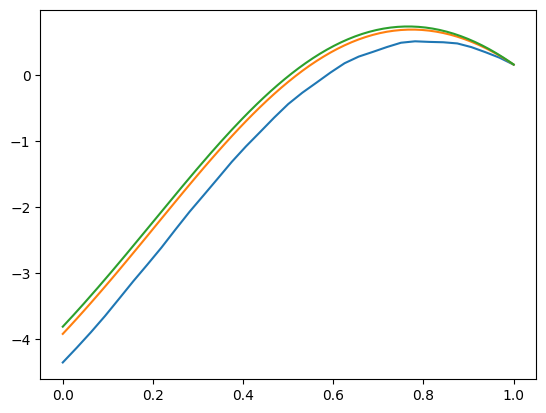

In [24]:
#ψ2
zic=5*2
println(maximum(ψ1c[end,:].-ψ2c[1,:]))
println(maximum(ψ1m[end,:].-ψ2m[1,:]))
println(maximum(ψ1f[end,:].-ψ2f[1,:]))
plot(xc, ψ2c[:,zic])
plot(xm, ψ2m[:,2*zic-1])
plot(xf, ψ2f[:,4*zic-3])
println(tc)
println(zc[zic])
println(zm[2*zic-1])
println(zf[4*zic-3])

15.5625

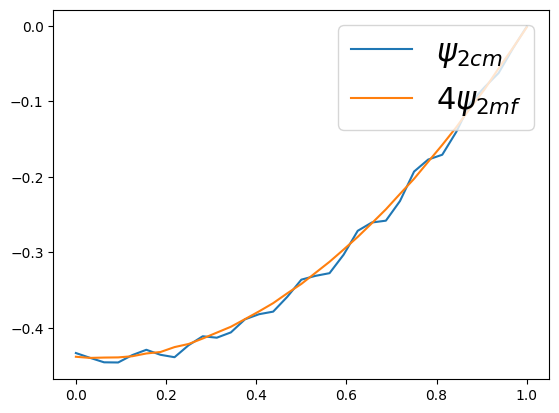

In [25]:
ψ2cm = ψ2c - ψ2m[1:2:end,1:2:end]
ψ2mf = ψ2m[1:2:end,1:2:end] - ψ2f[1:4:end,1:4:end]

plot(xc, ψ2cm[:,zic], label =L"\psi_{2cm}")
plot(xc, 4*ψ2mf[:,zic], label =L"4\psi_{2mf}")
legend(fontsize="22", loc=1)
print(tc)

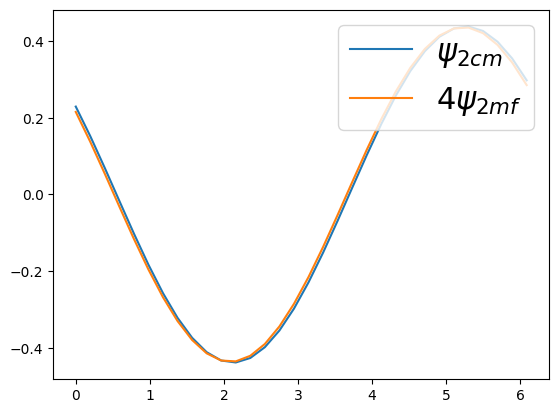

PyObject <matplotlib.legend.Legend object at 0x7f036229eb38>

In [26]:
plot(zc, ψ2cm[xic,:], label =L"\psi_{2cm}")
plot(zc, 4*ψ2mf[xic,:], label =L"4\psi_{2mf}")
legend(fontsize="22", loc=1)